In [1]:
#Importing required packages

import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [2]:
# cleaned up '#' in txt file before reading -> for correct header
df = pd.read_csv("testpattern06_d4.0_R3.0_roving.txt",delim_whitespace=True)
df=df.drop(['#'], axis=1)
df.head()

,Stitch_number_modified,Stitch_path_length,x,y,measured_x1,measured_y1,measured_x2,measured_y2,measured_xm,measured_ym,Deviation_tot,Width,Radius_loc,Radius_locav,Radius_locav2,Radius_locav3
0,1,0.0000,511.3638,-19.0811,510.8245,-17.9730,511.8639,-20.1088,511.3442,-19.0409,0.0447,2.3753,inf,299.8505,17.5033,11.7315
1,1,0.9591,512.3229,-19.0894,511.7820,-18.0891,512.8518,-20.0677,512.3169,-19.0784,0.0125,2.2493,inf,150.5194,15.6020,11.2740
2,1,1.9183,513.2820,-19.0977,512.7094,-18.1517,513.8795,-20.0851,513.2945,-19.1184,0.0242,2.2598,inf,81.0540,13.9990,10.8555
3,1,2.9018,514.2654,-19.1060,513.6625,-18.2269,514.9383,-20.0871,514.3004,-19.1570,0.0618,2.2557,-146.6106,45.6545,12.6165,10.4644
4,1,3.9667,515.3302,-19.1225,514.5880,-18.1910,516.1352,-20.1328,515.3616,-19.1619,0.0504,2.4828,-470.9179,26.2507,11.3705,10.0818


In [3]:
#checking information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Stitch_number_modified  2155 non-null   int64  
 1   Stitch_path_length      2155 non-null   float64
 2   x                       2155 non-null   float64
 3   y                       2155 non-null   float64
 4   measured_x1             2155 non-null   float64
 5   measured_y1             2155 non-null   float64
 6   measured_x2             2155 non-null   float64
 7   measured_y2             2155 non-null   float64
 8   measured_xm             2155 non-null   float64
 9   measured_ym             2155 non-null   float64
 10  Deviation_tot           2155 non-null   float64
 11  Width                   2155 non-null   float64
 12  Radius_loc              2155 non-null   float64
 13  Radius_locav            2155 non-null   float64
 14  Radius_locav2           2155 non-null   

In [4]:
#Implementing of slicing window method to the dataset
n = 5
x_values = np.lib.stride_tricks.sliding_window_view(df['x'].values, n)
y_values = np.lib.stride_tricks.sliding_window_view(df['y'].values, n)
x_values=x_values-x_values[:,n//2][:,np.newaxis]
y_values=y_values-y_values[:,n//2][:,np.newaxis]
target = np.lib.stride_tricks.sliding_window_view(df['Deviation_tot'].values, n)[:,n//2].copy()
#features = pd.concat([pd.DataFrame(x_values.copy()), pd.DataFrame(y_values.copy())], axis = 1)
features = np.concatenate((x_values,y_values), axis=1)
# drop 0 columns:
features = features[:,[i for i in range(2*n) if i!=n//2 and i!=(n+n//2)]].copy()


In [5]:
ind = np.random.permutation(np.arange(len(features))) # random permutation of dataset
features = features[ind].copy()
target = target[ind].copy()[:,np.newaxis]
print("Matrix sizes of input and output data", features.shape, target.shape)

Matrix sizes of input and output data (2151, 8) (2151, 1)


In [6]:
#splitting the dataset into train and test

input_data = torch.Tensor(features)
target_data = torch.Tensor(target)
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.33)


In [7]:
#CNN structure
class MyModel(nn.Module):
    def __init__(self, n_features):
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(n_features, 16)
        self.layer2 = nn.Linear(16, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16,8)
        self.layer5 = nn.Linear(8,1)
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.relu(x)
        x = self.layer4(x)
        x = torch.relu(x)
        x = self.layer5(x)
        return x

In [8]:
#compiling the model
model = MyModel(n_features=features.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


In [9]:
#Training the models

losses = []
for epoch in range(3000):

    # Forward pass
    output = model(input_data)

    # Compute loss
    loss = criterion(output, target_data)
    #r


    # Backward pass and update
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

 # Print loss
    if epoch % 10 == 0:
       losses.append(float(loss.item()))
       print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 2.7910919189453125
Epoch 10, Loss: 2.6252377033233643
Epoch 20, Loss: 2.4249446392059326
Epoch 30, Loss: 2.2369813919067383
Epoch 40, Loss: 2.1992900371551514
Epoch 50, Loss: 2.1428945064544678
Epoch 60, Loss: 2.0990302562713623
Epoch 70, Loss: 2.035780668258667
Epoch 80, Loss: 1.9435425996780396
Epoch 90, Loss: 1.8118789196014404
Epoch 100, Loss: 1.643856406211853
Epoch 110, Loss: 1.460170030593872
Epoch 120, Loss: 1.3156661987304688
Epoch 130, Loss: 1.2344390153884888
Epoch 140, Loss: 1.1764404773712158
Epoch 150, Loss: 1.1229444742202759
Epoch 160, Loss: 1.0656064748764038
Epoch 170, Loss: 1.00240159034729
Epoch 180, Loss: 0.9330847263336182
Epoch 190, Loss: 0.8521615862846375
Epoch 200, Loss: 0.763542890548706
Epoch 210, Loss: 0.665502667427063
Epoch 220, Loss: 0.561177134513855
Epoch 230, Loss: 0.45254072546958923
Epoch 240, Loss: 0.35067054629325867
Epoch 250, Loss: 0.2640759348869324
Epoch 260, Loss: 0.2054159939289093
Epoch 270, Loss: 0.17113086581230164
Epoch 28

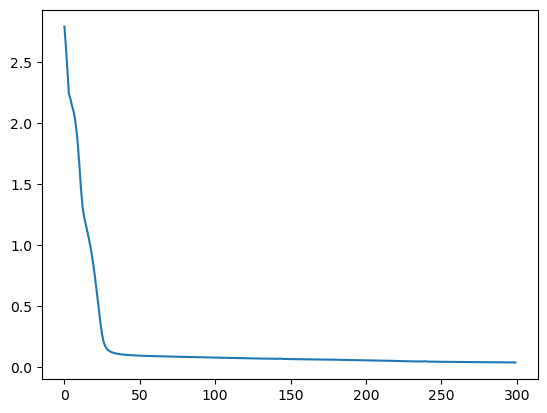

In [10]:
#plotting the losses
plt.plot(losses)


### Evaluating the model over the test data

In [11]:
y_pred = model(X_test)
print(f"MSE over the model prediction: {mean_absolute_error(y_test.tolist(), y_pred.tolist())}")

MSE over the model prediction: 0.13182919383078526


In [12]:
resort = np.argsort(ind)
test= features[resort,:]
prediction = model(torch.Tensor(test))[:,0]
test = prediction.detach().numpy().flatten()
test

array([0.12966792, 0.13704647, 0.08017336, ..., 0.26944834, 0.20074947,
       0.24333756], dtype=float32)

In [13]:
target[resort,0]

array([0.0242, 0.0618, 0.0504, ..., 0.111 , 0.0239, 0.0189])

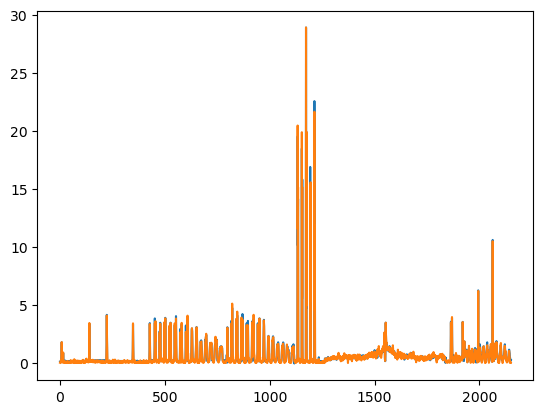

In [14]:
# plot prediction and difference between prediction and actual target
plt.plot(test)
plt.plot(target[resort,0])

### Testing over the test data

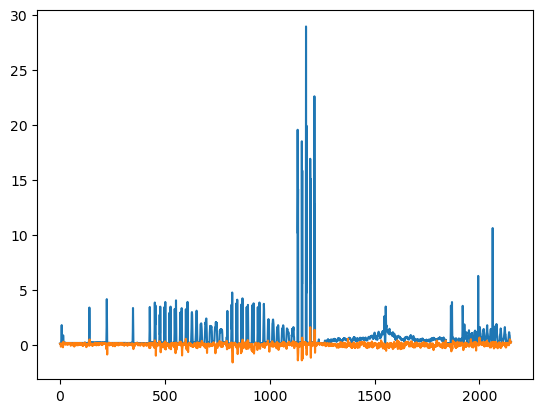

In [15]:
plt.plot(test)
plt.plot(test-target[resort,0])